In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import copy
import matplotlib.pyplot as plt


# Define the attributes of a state
battery_levels = ['Low', 'High']
wind_conditions = ['Calm', 'Windy']
Mud_conditions = ['Yes', 'No']
x_values = [1, 2, 3, 4, 5]
y_values = [1, 2, 3, 4, 5]

# Create a list of all possible states using attribute combinations
states = []
for battery in battery_levels:
    for wind in wind_conditions:
        for Mud in Mud_conditions:
            for x in x_values:
                for y in y_values:
                    state = {'battery': battery, 'wind': wind, 'Mud': Mud, 'x': x, 'y': y}
                    states.append(state)


# Define the actions
actions = ['move up', 'move down', 'move right', 'move left', 'stay']

# Define the constraints
constraints = ["c1"]
    
def Constraint(state, constraint):
    if constraint == "c1":
        if (state['x'] <= 2 and state['y'] == 2) or (state['x'] == 4 and state['y'] > 2):
            return True
        else:
            return False 
    else:
        return False  # Return False for undefined constraints   

In [2]:
def get_next_state(current_state, action):
    next_state = current_state.copy()
    
    # If the action is 'stay,' keep all conditions the same
    if action == 'stay':
        return next_state  # No need to update anything
    
    if action == 'move up':
        if next_state['x'] > 1:
            next_state['x'] -= 1
        else:
            # Agent is at the top boundary, cannot move up
            return next_state
    elif action == 'move down':
        if next_state['x'] < 5:
            next_state['x'] += 1
        else:
            # Agent is at the bottom boundary, cannot move down
            return next_state
    elif action == 'move right':
        if next_state['y'] < 5:
            next_state['y'] += 1
        else:
            # Agent is at the right boundary, cannot move right
            return next_state
    elif action == 'move left':
        if next_state['y'] > 1:
            next_state['y'] -= 1
        else:
            # Agent is at the left boundary, cannot move left
            return next_state
    else:
        raise ValueError(f"Invalid action: {action}")  # Raise an error for invalid actions
        
    # Update 'wind' attribute based on the 'x' and 'y' coordinates
    if (next_state['x'] <= 2 and next_state['y'] <= 2) or ( next_state['x'] >= 4 and next_state['y'] >= 4) or\
                                                   ( next_state['x'] == 3 and next_state['y'] >= 4) :
        next_state['wind'] = 'Windy'
    else:
        next_state['wind'] = 'Calm'
        
    # Update 'battery' attribute
    if state['battery'] == 'Low':
        next_state['battery'] = 'High'
     
    # Update 'obstacle' attribute
    if (next_state['x'] == 4 and next_state['y'] > 2) or ( next_state['x'] == 3 and next_state['y'] == 2):
        next_state['Mud'] = 'Yes'
    else:
        next_state['Mud'] = 'No'
    
    return next_state    

In [3]:
def is_final_state(state):
    return state['Mud'] == 'No' and state['x'] == 5 and state['y'] == 5 and \
                            state['battery'] == 'High' and state['wind'] == 'Calm'

def calculate_reward(action, next_state):
    if  is_final_state(next_state):
        return 10.0  # big positive reward for reaching the final state 
    elif next_state['Mud'] == 'No' :
        return 1.0  # small Positive reward for collecting a sweet
    else:
        return -1.0  # negative reward for other states or actions

def epsilon_greedy(state, epsilon, beta):
    if np.random.uniform() < epsilon:
        return random.choice(actions)  # Explore
    else:
        q_values = Q[tuple(state.items())]
        u_values = U[tuple(state.items())]
        
        # Calculate the combined values (Q - beta * U) for each action
        combined_values = {action: q_values[action] - beta * u_values[action] for action in actions}
        
        # Choose the action with the maximum combined value
        optimal_action = max(combined_values, key=combined_values.get)
        return optimal_action  # Exploit


## beta= 1

In [4]:
# Define constants
time_steps = 1500
num_episodes = 2000
num_trials = 20
epsilon_min = 0.02
decay_rate = 0.995

# Define learning parameters
learning_rate = 0.01
discount_factor = 0.95
beta = 1

# Define threshold values
thresholds = {"c1": 0.001}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9


    # Dictionary to store Q-values
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedy(state, epsilon, beta)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
            probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
            violation_measure = 0.0
            for constraint, probability in probabilities.items():
                violation = max(0, probability - thresholds[constraint])
                violation_measure += violation
                violation_measure /= len(constraints)

            
            # Calculate the maximum U-value for the next state for U-learning
            if tuple(next_state.items()) in U:
                min_next_u_value = min(U[tuple(next_state.items())].values())

            u_value_update = (1 - learning_rate) * U[state_tuple][action] + \
                            learning_rate * (violation_measure + discount_factor * min_next_u_value)

            # Update the U-value for the current state-action pair for U-learning
            U[state_tuple][action] = u_value_update

            
            total_violation +=violation_measure

            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the values of reward and violation after each TRIAL
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 
    
average_rewards = [(sum(r[i] for r in rewards_per_trial)) / num_trials for i in range(num_episodes)] 
average_violations = [(sum(v[i] for v in violations_per_trial)) / num_trials for i in range(num_episodes)]   

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

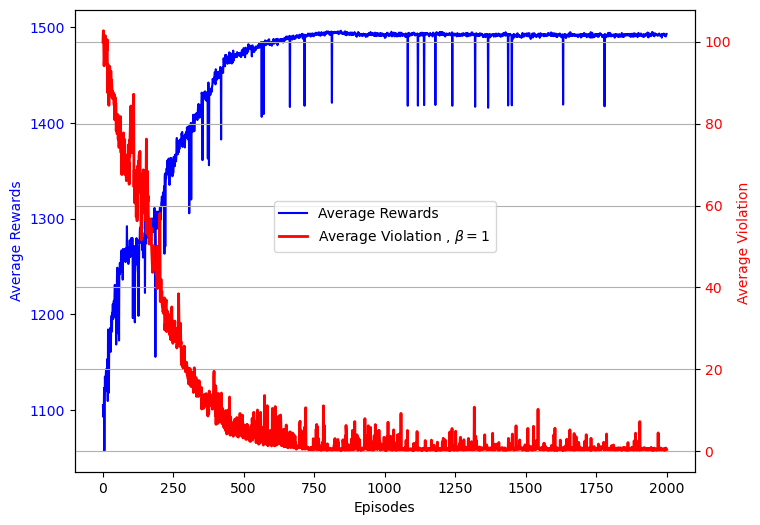

In [5]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [(sum(r[i] for r in rewards_per_trial)) / num_trials for i in range(num_episodes)] 

ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='blue')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [(sum(v[i] for v in violations_per_trial)) / num_trials for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='red', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=1$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))

# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=1$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

## beta= 5

In [6]:
# Define parameters
learning_rate = 0.01
discount_factor = 0.95
time_steps = 1500
num_episodes = 2000
num_trials = 20
beta= 5

epsilon = 0.9
epsilon_min = 0.02
decay_rate = 0.995

# Define threshold values
thresholds = {"c1": 0.001}

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9
    
    # Dictionary to store Q-values
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

    
    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedy(state, epsilon, beta)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
                probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
                violation_measure = 0.0
                for constraint, probability in probabilities.items():
                    violation = max(0, probability - thresholds[constraint])
                    violation_measure += violation
                violation_measure /= len(constraints)


            # Calculate the maximum U-value for the next state for U-learning
            if tuple(next_state.items()) in U:
                min_next_u_value = min(U[tuple(next_state.items())].values())

            u_value_update = (1 - learning_rate) * U[state_tuple][action] + \
                            learning_rate * (violation_measure + discount_factor * min_next_u_value)

            # Update the U-value for the current state-action pair for U-learning
            U[state_tuple][action] = u_value_update

            total_violation +=violation_measure


            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the last values of reward and violation after each episode
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

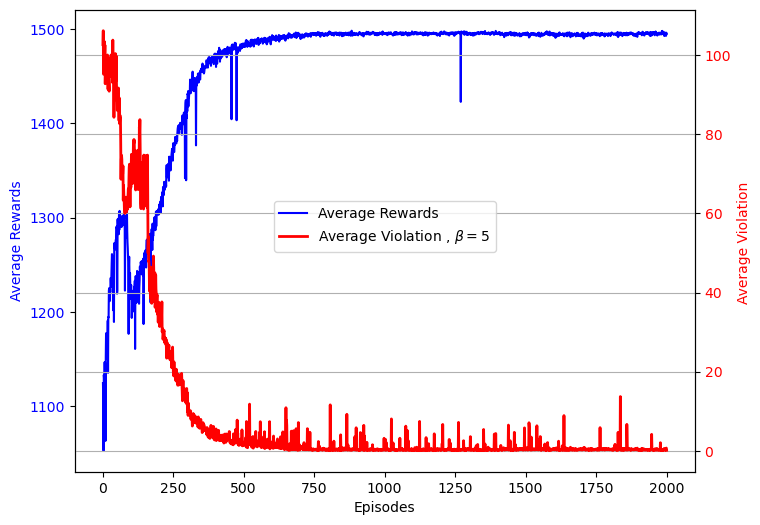

In [7]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [sum(rewards[i] for rewards in rewards_per_trial) / num_trials for i in range(num_episodes)] 
ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='blue')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [sum(violations[i] for violations in violations_per_trial) / num_trials 
                      for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='red', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=5$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))

# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=5$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

## beta= 15

In [8]:
# Define parameters
learning_rate = 0.01
discount_factor = 0.95
time_steps = 1500
num_episodes = 2000
num_trials = 20
beta= 15

epsilon = 0.9
epsilon_min = 0.02
decay_rate = 0.995

# Define threshold values
thresholds = {"c1": 0.001}

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9
    
    # Dictionary to store Q-values
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    U = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    
    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedy(state, epsilon, beta)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
                probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
                violation_measure = 0.0
                for constraint, probability in probabilities.items():
                    violation = max(0, probability - thresholds[constraint])
                    violation_measure += violation
                violation_measure /= len(constraints)


            # Calculate the maximum U-value for the next state for U-learning
            if tuple(next_state.items()) in U:
                min_next_u_value = min(U[tuple(next_state.items())].values())

            u_value_update = (1 - learning_rate) * U[state_tuple][action] + \
                            learning_rate * (violation_measure + discount_factor * min_next_u_value)

            # Update the U-value for the current state-action pair for U-learning
            U[state_tuple][action] = u_value_update

            total_violation +=violation_measure


            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the last values of reward and violation after each episode
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

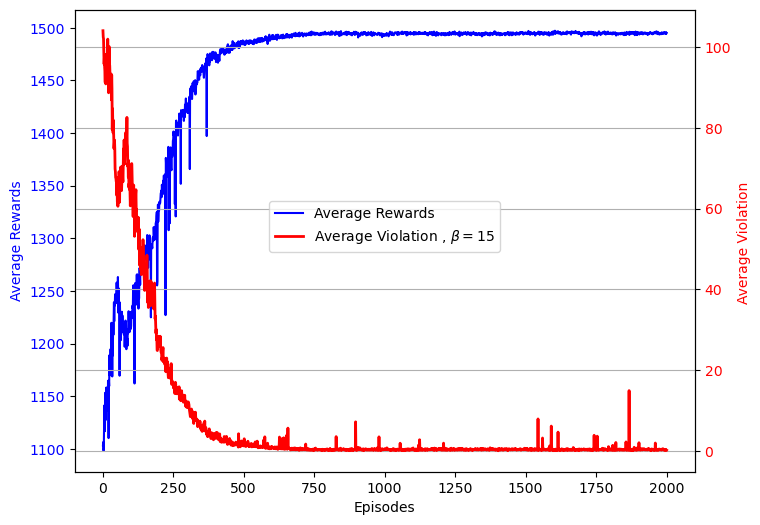

In [9]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [sum(rewards[i] for rewards in rewards_per_trial) / num_trials for i in range(num_episodes)] 
ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='blue')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [sum(violations[i] for violations in violations_per_trial) / num_trials 
                      for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='red', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=15$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))
# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=15$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

# Constraint inside reward

In [10]:
def calculate_reward(action, next_state, constraint, thresholds, num_episodes, count_per_constraint,beta):
    # Define the violation measure
    violation_measure = 0.0

    for constraint in constraints:
        if  Constraint(next_state, constraint):
            count_per_constraint[constraint] += 1
        probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

    # Calculate the violation measure for each constraint
        for constraint, count in count_per_constraint.items():
            probability = count / num_episodes
            violation = max(0, probability - thresholds.get(constraint, 0))

            violation_measure += violation

        violation_measure /= len(constraints)

    if next_state['Mud'] == 'No':
        return 1.0 -  beta*violation_measure  # Subtract penalty for violation
    elif is_final_state(next_state):
        return 10.0 -  beta*violation_measure  # Subtract penalty for violation
    else:
        return -1.0 -  beta*violation_measure  # Negative reward with penalty for violation
    

def epsilon_greedyq(state, epsilon):
    if np.random.uniform() < epsilon:
        return random.choice(actions)  # Explore
    else:
        return max(Q[tuple(state.items())], key=Q[tuple(state.items())].get)  # Exploit

## beta=1

In [11]:
# Define parameters
learning_rate = 0.01
discount_factor = 0.95
time_steps = 1500
num_episodes = 2000
epsilon = 0.9
epsilon_min = 0.02
decay_rate = 0.995
num_trials=20
beta=1

# Define threshold values
thresholds = {"c1": 0.001}

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9
    
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    
    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedyq(state, epsilon)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state, constraints, thresholds, num_episodes, 
                                      count_per_constraint, beta)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
                probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
                violation_measure = 0.0
                for constraint, probability in probabilities.items():
                    violation = max(0, probability - thresholds.get(constraint, 0))
                    violation_measure += violation
                violation_measure /= len(constraints)

            total_violation +=violation_measure


            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the last values of reward and violation after each episode
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

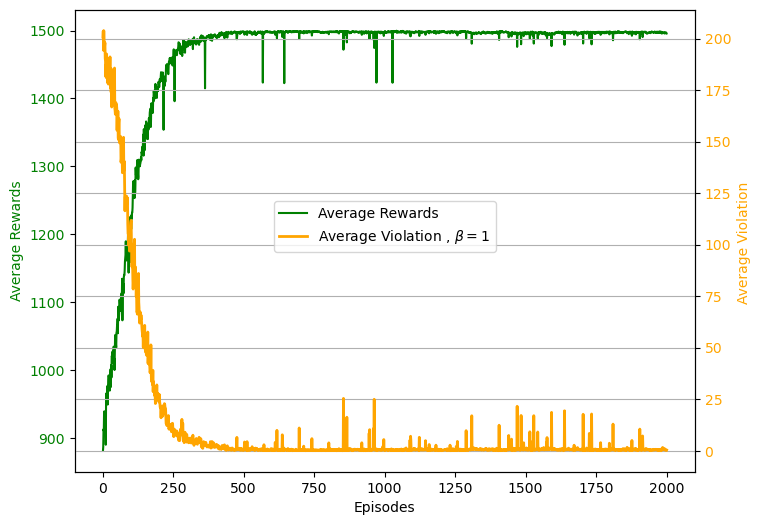

In [12]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [sum(rewards[i] for rewards in rewards_per_trial) / num_trials for i in range(num_episodes)] 
ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='green')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [sum(violations[i] for violations in violations_per_trial) / num_trials 
                      for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='orange', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=1$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))

# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=1$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

## beta=5

In [13]:
# Define parameters
learning_rate = 0.01
discount_factor = 0.95
time_steps = 1500
num_episodes = 2000
epsilon = 0.9
epsilon_min = 0.02
decay_rate = 0.995
num_trials=20
beta=5

# Define threshold values
thresholds = {"c1": 0.001}

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9
    
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    
    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedyq(state, epsilon)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state, constraints, thresholds, num_episodes, 
                                      count_per_constraint, beta)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if  Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
                probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
                violation_measure = 0.0
                for constraint, probability in probabilities.items():
                    violation = max(0, probability - thresholds.get(constraint, 0))
                    violation_measure += violation
                violation_measure /= len(constraints)

            total_violation +=violation_measure


            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the last values of reward and violation after each episode
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

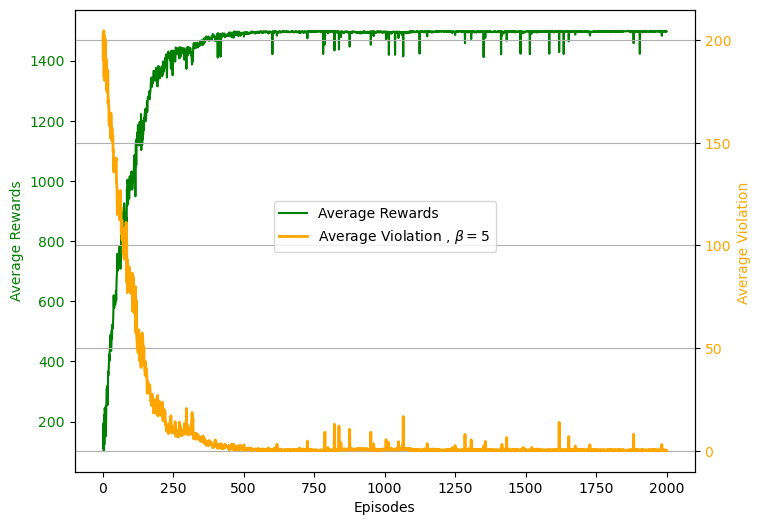

In [14]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [sum(rewards[i] for rewards in rewards_per_trial) / num_trials for i in range(num_episodes)] 
ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='green')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [sum(violations[i] for violations in violations_per_trial) / num_trials 
                      for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='orange', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=5$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))

# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=5$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

## beta=15

In [15]:
# Define parameters
learning_rate = 0.01
discount_factor = 0.95
time_steps = 1500
num_episodes = 2000
epsilon = 0.9
epsilon_min = 0.02
decay_rate = 0.995
num_trials=20
beta=15

# Define threshold values
thresholds = {"c1": 0.001}

# Dictionary to store Q-values
Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}

# Lists to store rewards and violations across trials
rewards_per_trial = []
violations_per_trial = []

# Main loop for trials
for trial in range(num_trials):
    rewards = []
    violations = []
    
    # Reset epsilon at the beginning of each trial
    epsilon = 0.9
    
    Q = {tuple(state.items()): {action: 0.0 for action in actions} for state in states}
    
    # Simulate explorations and update Q-values and U-values
    for i in range(num_episodes):
        state = random.choice(states)
        total_reward = 0
        total_violation = 0

        # Dictionary to store the count of unsatisfying constraints
        count_per_constraint = {constraint: 0 for constraint in constraints}

        for t in range(time_steps):
            # Choose action using epsilon-greedy policy for Q-learning
            action = epsilon_greedyq(state, epsilon)
            next_state = get_next_state(state, action) 

            # Check if the current state is the final state for Q-learning
            if is_final_state(next_state): 
                break  # Terminate the episode if it's a final state

            # Calculate the reward for the next state
            reward = calculate_reward(action, next_state, constraints, thresholds, num_episodes, 
                                      count_per_constraint, beta)

            # Convert the state dictionary into a tuple for using it as a key
            state_tuple = tuple(state.items())   

            # Calculate the maximum Q-value for the next state
            if tuple(next_state.items()) in Q:
                max_next_q_value = max(Q[tuple(next_state.items())].values())


            q_value_update = (1 - learning_rate) * Q[state_tuple][action] + \
                             learning_rate * (reward + discount_factor * max_next_q_value)

            # Update the Q-value for the current state-action pair for Q-learning
            Q[state_tuple][action] = q_value_update

            total_reward += reward

            # Compute probabilities
            for constraint in constraints:
                if Constraint(next_state, constraint):
                    count_per_constraint[constraint] += 1
                probabilities = {constraint: count / num_episodes for constraint, count in count_per_constraint.items()}

                    # Calculate the violation measure
                violation_measure = 0.0
                for constraint, probability in probabilities.items():
                    violation = max(0, probability - thresholds.get(constraint, 0))
                    violation_measure += violation
                violation_measure /= len(constraints)

            total_violation +=violation_measure


            state = next_state      

        rewards.append(total_reward)
        violations.append(total_violation)
        epsilon = max(epsilon * decay_rate, epsilon_min)

        if (i + 1) % 100 == 0:
            print(f'Trial {trial + 1}, Episode {i + 1}: epsilon = {epsilon:.4f}')
            
    # Save the last values of reward and violation after each episode
    rewards_per_trial.append(rewards)
    violations_per_trial.append(violations) 

Trial 1, Episode 100: epsilon = 0.5452
Trial 1, Episode 200: epsilon = 0.3303
Trial 1, Episode 300: epsilon = 0.2001
Trial 1, Episode 400: epsilon = 0.1212
Trial 1, Episode 500: epsilon = 0.0734
Trial 1, Episode 600: epsilon = 0.0445
Trial 1, Episode 700: epsilon = 0.0269
Trial 1, Episode 800: epsilon = 0.0200
Trial 1, Episode 900: epsilon = 0.0200
Trial 1, Episode 1000: epsilon = 0.0200
Trial 1, Episode 1100: epsilon = 0.0200
Trial 1, Episode 1200: epsilon = 0.0200
Trial 1, Episode 1300: epsilon = 0.0200
Trial 1, Episode 1400: epsilon = 0.0200
Trial 1, Episode 1500: epsilon = 0.0200
Trial 1, Episode 1600: epsilon = 0.0200
Trial 1, Episode 1700: epsilon = 0.0200
Trial 1, Episode 1800: epsilon = 0.0200
Trial 1, Episode 1900: epsilon = 0.0200
Trial 1, Episode 2000: epsilon = 0.0200
Trial 2, Episode 100: epsilon = 0.5452
Trial 2, Episode 200: epsilon = 0.3303
Trial 2, Episode 300: epsilon = 0.2001
Trial 2, Episode 400: epsilon = 0.1212
Trial 2, Episode 500: epsilon = 0.0734
Trial 2, Episo

Trial 11, Episode 800: epsilon = 0.0200
Trial 11, Episode 900: epsilon = 0.0200
Trial 11, Episode 1000: epsilon = 0.0200
Trial 11, Episode 1100: epsilon = 0.0200
Trial 11, Episode 1200: epsilon = 0.0200
Trial 11, Episode 1300: epsilon = 0.0200
Trial 11, Episode 1400: epsilon = 0.0200
Trial 11, Episode 1500: epsilon = 0.0200
Trial 11, Episode 1600: epsilon = 0.0200
Trial 11, Episode 1700: epsilon = 0.0200
Trial 11, Episode 1800: epsilon = 0.0200
Trial 11, Episode 1900: epsilon = 0.0200
Trial 11, Episode 2000: epsilon = 0.0200
Trial 12, Episode 100: epsilon = 0.5452
Trial 12, Episode 200: epsilon = 0.3303
Trial 12, Episode 300: epsilon = 0.2001
Trial 12, Episode 400: epsilon = 0.1212
Trial 12, Episode 500: epsilon = 0.0734
Trial 12, Episode 600: epsilon = 0.0445
Trial 12, Episode 700: epsilon = 0.0269
Trial 12, Episode 800: epsilon = 0.0200
Trial 12, Episode 900: epsilon = 0.0200
Trial 12, Episode 1000: epsilon = 0.0200
Trial 12, Episode 1100: epsilon = 0.0200
Trial 12, Episode 1200: eps

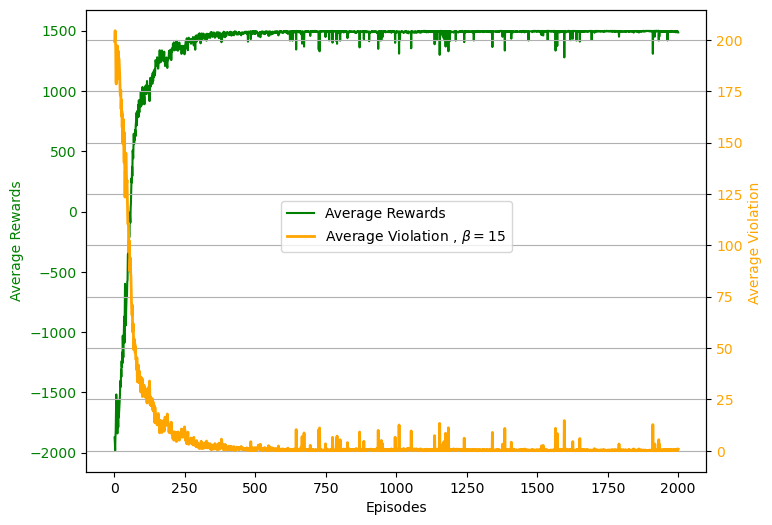

In [16]:
# Create a figure and the first y-axis (for accumulated rewards)
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accumulated rewards with a label
#average_rewards = [sum(last_rewards) / num_trials] * num_episodes
average_rewards = [sum(rewards[i] for rewards in rewards_per_trial) / num_trials for i in range(num_episodes)] 
ax1.plot(range(1, num_episodes + 1), average_rewards, label='Average Rewards', color='green')

# Set the y-axis label for accumulated rewards
ax1.set_ylabel('Average Rewards', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlabel('Episodes')


# Create the second y-axis (for average violation measures)
ax2 = ax1.twinx()

# Plot average violation measures (scaled for better visualization) with a label
#average_violations = [sum(last_violations) / num_trials] * num_episodes
average_violations = [sum(violations[i] for violations in violations_per_trial) / num_trials 
                      for i in range(num_episodes)]    
ax2.plot(range(1, num_episodes + 1), average_violations, label='Average Violation ', color='orange', linewidth=2.0)

# Set the y-axis label for average violation measures
ax2.set_ylabel('Average Violation ', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend to distinguish the lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
labels[-1] = f'{labels[-1]}, $\\beta=15$'

plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.6))

# Set a title for the graph
#plt.title(r'Average Rewards and Average Violation Measure Over Episodes (Across Trials), $\beta=15$')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [17]:
# Define the parameter beta to control the trade-off between Q and U
beta = 15  # You can adjust this value as needed

# Dictionary to store the optimal policy
policy = {}

# Iterate through all states to compute the optimal policy
for state_tuple, q_values_for_state in Q.items():
    state = dict(state_tuple)
    optimal_action = None
    max_value = float('-inf')
    
    for action, q_value in q_values_for_state.items():
        u_value = U[state_tuple][action]
        value = q_value - beta * u_value
        
        if value > max_value:
            max_value = value
            optimal_action = action
    
    # Store the optimal action for this state in the policy dictionary
    policy[state_tuple] = optimal_action

# Print the computed optimal policy
for state_tuple, optimal_action in policy.items():
    state = dict(state_tuple)
    print(f"Optimal action for state {state}: {optimal_action}")


Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 1, 'y': 1}: move right
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 1, 'y': 2}: move down
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 1, 'y': 3}: move left
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 1, 'y': 4}: move right
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 1, 'y': 5}: move down
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 2, 'y': 1}: move up
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 2, 'y': 2}: move up
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 2, 'y': 3}: move right
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 2, 'y': 4}: move up
Optimal action for state {'battery': 'Low', 'wind': 'Calm', 'Mud': 'Yes', 'x': 2, 'y': 5}: mov

In [18]:
# # Redirect output to a file
# with open("policy_matrix.txt", "w") as file:
#     for state_tuple, optimal_action in policy.items():
#         state = dict(state_tuple)
#         row = [""] * 20  # Assuming you have 20 states in each row
#         x, y = state['x'], state['y']
#         row[x] = optimal_action
#         file.write("[" + ", ".join(f"'{action}'" if action else "''" for action in row) + "]\n")

# # Print a message indicating that the file has been written
# print("Policy matrix has been written to 'policy_matrix.txt'")